Today we will touch:
* The Bias-Variance Decomposition
* Resampling methods
  * Cross-Validation
  * Leave-One-Out Cross-Validation
  * The Bootstrap
* Probabilistic Statistical Measures
  * The Bayesian Approach and BIC
  * Minimum Description Length
* Vapnik-Chervonenkis Dimension


In [ ]:
# Prerequisites
install.packages("leaps", quiet=TRUE)
install.packages("ggplot2", quiet=TRUE)
install.packages("reshape2", quiet=TRUE)

also installing the dependency ‘plyr’




**Model selection**: estimating the performance of different models in order to choose the best one.

**Model assessment**: having chosen a final model, estimating its predic-
tion error (generalization error) on new data.

AIC, BIC, MDL & SRM approximate the validation step analytically.

Cross-validation and the bootstrap are for efficient sample re-use.

# The Bias-Variance Decomposition


Let's start with generated data. We are going to generate ***n*** points where the ***x*** values are uniformly distributed between ***−xlim*** and ***xlim***, and the ***y*** values are the sum of the quadratic function ***f*** and a normally distributed error (parameter ***var***).

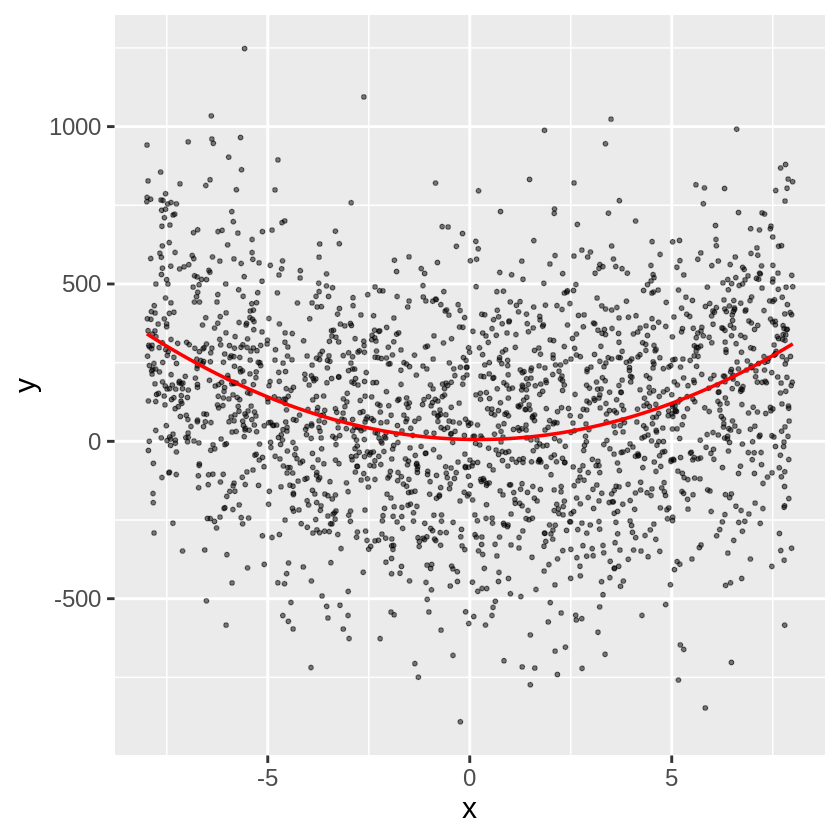

In [ ]:
## Hyperparameters
n = 2000
n.train = 500
xlim = 8
var = 300
n.degree = 20
set.seed(42)

## Data generation
error = var*rnorm(n,0,1)
f = function(x) 5*x^2-2*x+6
x = runif(n, -xlim, xlim)
y = f(x) + error
data = data.frame(x=poly(x, degree = n.degree, raw = TRUE), y=y)

library(ggplot2)
ggplot(data, aes(x,y)) +
  geom_point(size = 1, alpha = 0.5) +
  stat_function(fun = f, colour = "red", size = 1) + theme_grey(base_size = 18)

The figure shows the scatter plot of the generated data. The red curve is the function from which the data was generated.

If we adjust the points by a polynomial of order 2 we can check the associated RMSE:

In [ ]:
ind.train = sample(1:n, n.train, replace = FALSE)
train = data[ind.train,]
test = data[-ind.train,]
fit = lm(y ~ x.1+x.2, train)
pred = predict(fit, newdata = test)
RMSE_train = sqrt(sum((fit$fitted.values-train$y)^2)/nrow(train))
RMSE_test = sqrt(sum((pred-test$y)^2)/nrow(test))
data.frame(train = RMSE_train, test = RMSE_test)

train,test
<dbl>,<dbl>
294.2543,302.0552


Note that test RMSE is larger than train RMSE, on average.

We will check how RMSE performs as a function of degrees of freedom, for several linear regressions (linear due to the linear dependence of regression coefficients). To do this we will first create a function that for a given partition in training and test, and the degree of the polynomial by which we want to adjust the data, returns the RSME in the training and test sets.

In [ ]:
f.degree = function(dg, train, test){
  train.dg = train[, c(1:dg, ncol(train))]
  test.dg = test[, c(1:dg, ncol(train))]
  fit = lm(y ~., train.dg)
  pred = predict(fit, newdata = test.dg)
  RMSE_train = sqrt(sum((fit$fitted.values-train.dg$y)^2)/nrow(train.dg))
  RMSE_test = sqrt(sum((pred-test.dg$y)^2)/nrow(test.dg))
  RMSE = data.frame(train = RMSE_train, test = RMSE_test)
  return(RMSE)
}
val.dg = function(dg) f.degree(dg, train, test)
val.dg(2)

train,test
<dbl>,<dbl>
294.2543,302.0552


Now we only have to use the function sapply to apply the function created val.dg on a vector with the degrees we want to test.

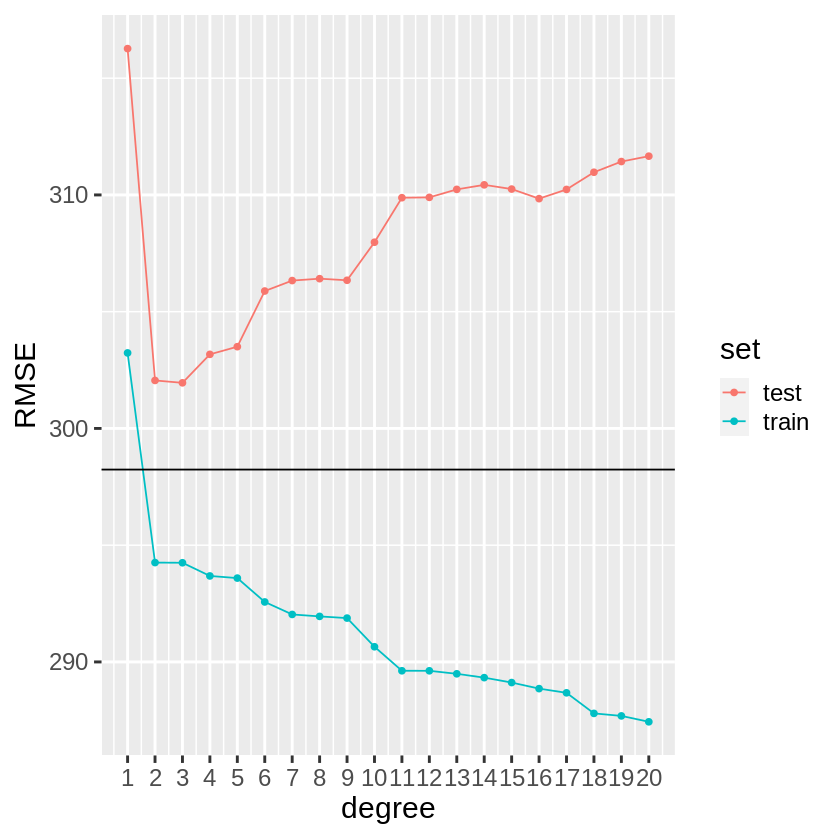

In [ ]:
degree = 1:n.degree
RMSE = sapply(degree, val.dg)
RMSE = data.frame(degree = rep(1:n.degree,2),
                  set = c(rep("train",n.degree),rep("test",n.degree)),
                  RMSE = c(unlist(RMSE[1,]), unlist(RMSE[2,])))
ggplot(RMSE, aes(x = degree, y = RMSE, color = set))+
  geom_point()+geom_line()+ scale_x_continuous(breaks = 1:n.degree) +
  theme(legend.position="right")+
  geom_abline(slope = 0, intercept = sd(error)) + theme_grey(base_size = 18)

In the figure above you can see the behavior of RMSE as a function of the complexity of the learning model (degrees of the polynomial). As the flexibility of the statistical learning method increases, we observe a monotone decrease in the training RMSE and a U-shape in the test RMSE. This is a fundamental property of statistical learning that holds regardless of the particular data set at hand and regardless of the statistical method being used. As model flexibility increases, training RMSE will decrease, but the test RMSE may not. When a given method yields a small training RMSE but a large RMSE, we are said to be *overfitting* the data.

The U-shape observed in the test RMSE curve turns out to be the result of two competing properties of statistical learning methods. It is possible to show that the expected test MSE (and also RMSE), for a given $x_0$, can always be decomposed into the sum of three fundamental quantities: the variance of $\hat{f}(x_0)$, the squared bias of $\hat{f}(x_0)$, and the variance of the error terms $\epsilon$. That is:
$$\mathbb{E}(y_0−\hat{f}(x0))^2 = \mathrm{Var}(\hat{f}(x_0))+[\mathrm{Bias}(\hat{f}(x_0))]^2+\mathrm{Var}(\epsilon)$$

Here the notation $\mathbb{E}(y_0−\hat{f}(x0))^2$ defines the expected test MSE, and refers to the average test MSE that we would obtain if we repeatedly estimated $f$ using a large number of training sets, and tested each at $x_0$.

The last equation tells us that in to minimize the expected test error we need to select statistical learning that simultaneously achieves low variance and low bias. Note that variance is inherently a nonnegative quantity, and squared bias is also nonnegative. Hence, we see that the expected test RMSE can never lie below $\mathrm{sd}(\epsilon)$, the irreducible error. In the previous graph, this irreducible error is represented by the black line.

Variance refers to the amount by which $\hat{f}$ would change if we estimated it using different training data set. If a method has high variance then small changes in the training data can result in large changes in $\hat{f}$. In general, more flexible statistical methods have higher variance. On the other hand, Bias, refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a much simpler model. Generally, more flexible methods result in less bias.

As expected by the way the data were generated the optimal number of degrees of freedom is 2. This is seen in the graph, as it is where you get the lowest RMSE value in the training and test sets, simultaneously.

# Resampling methods

In the previous section we discuss the distinction between the test error rate and the training error rate. The test error is the average error that results from using a statistical learning method to predict the response on a new observation. The test error can be easily calculated if a designated test is aailable. Unfortunately, this is usually not the case. In the absence of a very large designated test set that can be usaed to directly estimate the test error rate, a number of techniques can be used to estimate the test error rate.

Resampling methods, also known as cross-validation, it involves fitting the same statistical method multiple times using differents subsects of the data. In this topic we cover three approaches for assesing model performance:

* Validation set approach (or data split)
* k-fold Cross validation
* Leave One Out Cross Validation

The following sections describe the different resampling techniques.

In [ ]:
n.rep = 40
RMSE_train = data.frame(rep = matrix(0, nrow = n.degree, ncol = n.rep),
                  degree = 1:n.degree)
RMSE_test = data.frame(rep = matrix(0, nrow = n.degree, ncol = n.rep),
                        degree = 1:n.degree)
for (i in 1:n.rep){
  ind.train = sample(1:n, n.train, replace = FALSE)
  train = data[ind.train,]
  test = data[-ind.train,]
  degree = 1:n.degree
  temp = sapply(degree, val.dg)
  RMSE_train[,i] = unlist(temp[1,])
  RMSE_test[,i] = unlist(temp[2,])
}

### The plots
library(reshape2)

RMSE_train$set = "train"
RMSE_test$set = "test"
RMSE = rbind(RMSE_train, RMSE_test)
RMSE = melt(RMSE, id.vars = c("degree", "set"))

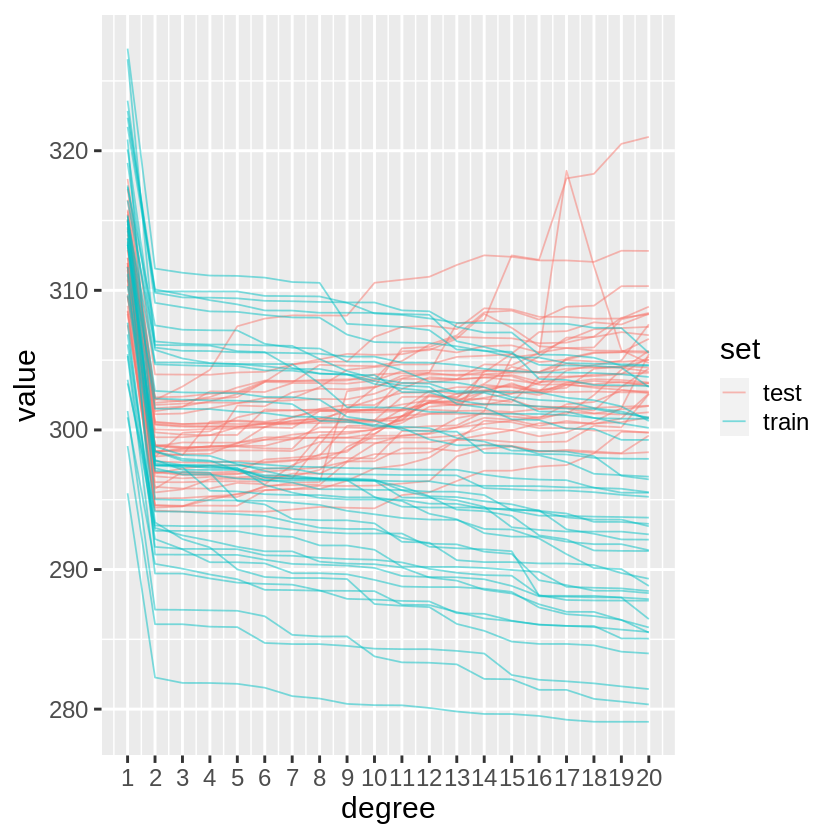

In [ ]:
# Plot with train and test
ggplot(RMSE) +
  aes(x = degree, y = value, group = interaction(variable, set), color = set) +
  geom_line(alpha = 0.5, size = 0.5) +
  scale_x_continuous(breaks = 1:n.degree) + theme_grey(base_size = 18)

## Cross-Validation

GCV = Generalized cross-validation

GCV provides a convenient approximation to leave-one out cross-validation, for linear fitting under squared-error loss.

$$\hat y = S y$$

$$\frac{1}{N} \sum_{i=1}^N{[y_i - \hat{f}^{-i}(x_i)]^2} = \frac{1}{N} \sum_{i=1}^N{[\frac{y_i - \hat{f}(x_i)}{1 - S_{ii}}]^2}$$

where $S_{ii}$ is the *i*th diagonal element of **S**. The GCV approximation is

$$\mathrm{GCV}(\hat{f}) = \frac{1}{N}\sum_{i=1}^N[\frac{y_i - \hat{f}(x_i)}{1 - \mathrm{trace}({S})/N}]^2$$

The quantity trace(**S**) is the effective number of parameters.

GCV can have a computational advantage in some settings, where the trace of **S** can be computed more easily than the individual elements $S_{ii}$. In smoothing problems, GCV can also alleviate the tendency of cross-validation to undersmooth. The similarity between GCV and AIC can be seen from the approximation $1/(1 - x)^2 \approx 1 + 2x$.

In [ ]:
n.fold = 5
RMSEk_train = data.frame(rep = matrix(0, nrow = n.degree, ncol = n.rep),
                         degree = 1:n.degree)
RMSEk_test = data.frame(rep = matrix(0, nrow = n.degree, ncol = n.rep),
                        degree = 1:n.degree)

for(j in 1:n.rep){
  RMSE_train = matrix(0, nrow = n.degree, ncol = n.fold)
  RMSE_test = matrix(0, nrow = n.degree, ncol = n.fold)
  data = data[sample(1:n),]
  for (i in 1:n.fold){
    ind_test = ((i-1)*(n/n.fold)+1):((n/n.fold)*i)
    train = data[-ind_test,]
    test = data[ind_test,]
    degree = 1:n.degree
    temp = sapply(degree, val.dg)
    RMSE_train[,i] = unlist(temp[1,])
    RMSE_test[,i] = unlist(temp[2,])
    }
  RMSEk_train[,j] = apply(RMSE_train, 1, mean)
  RMSEk_test[,j] = apply(RMSE_test, 1, mean)
}

### The plots
RMSEk_train$set = "train"
RMSEk_test$set = "test"
RMSE = rbind(RMSEk_train, RMSEk_test)
RMSE = melt(RMSE, id.vars = c("degree", "set"))

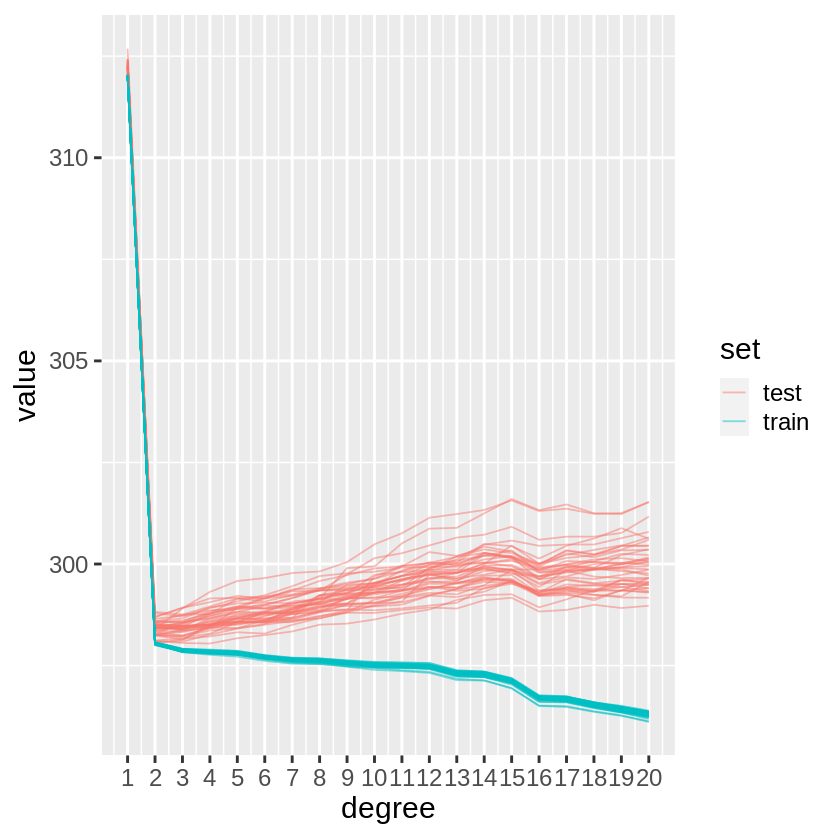

In [ ]:
# Plot with train and test
ggplot(RMSE) + aes(x = degree, y = value, group = interaction(variable, set), color = set) +
  geom_line(alpha = 0.5, size = 0.5)+ scale_x_continuous(breaks = 1:n.degree) + theme_grey(base_size = 18)

## Leave-One-Out Cross-Validation

LOOCV has the potential to be expensive to implement, since the model
has to be fit n times. This can be very time consuming if n is large, and if
each individual model is slow to fit. The following formula holds:

$$\mathrm{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^n (\frac{y_i - \hat{y}_i}{1 - h_i})^2$$

where $\hat{y}_i$ is the $i$th fitted value from the original least squares fit, and $h_i$ is the leverage:

$$h_i = \frac{1}{n} + \frac{(x_i - \bar{x})^2}{\sum_{i'=1}^n{(x_{i'} - \bar{x})^2}}$$


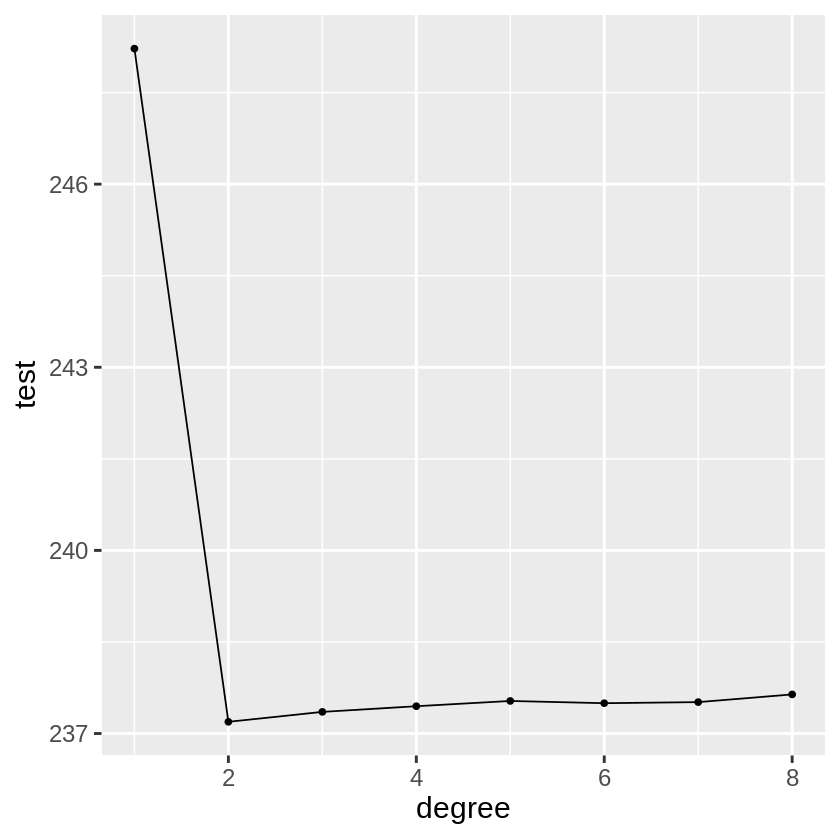

In [ ]:
n.degree = 8  # restrict the degree of the polynomial to avoid intensive calculations

RMSE_train = matrix(0, nrow = n.degree, ncol = n)
RMSE_test = matrix(0, nrow = n.degree, ncol = n)
for (i in 1:n){
  train = data[-i,]
  test = data[i,]
  degree = 1:n.degree
  temp = sapply(degree, val.dg)
  RMSE_train[,i] = unlist(temp[1,])
  RMSE_test[,i] = unlist(temp[2,])
}
LOOCV = data.frame(test = apply(RMSE_test, 1, mean),
                   degree = 1:n.degree)
ggplot(LOOCV, aes(x = degree, y = test))+
  geom_point()+geom_line() + theme_grey(base_size = 18)

## The Bootstrap

The bootstrap is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method.

The bootstrap seeks to estimate the conditional error $\mathrm{Err}_\tau$.
The training set is $\boldsymbol{Z} = (z_1, z_2,..., z_N)$, where $Z_i = (x_i, y_i)$. $B$ - number of bootstrap datasets.

$$\hat{\mathrm{Var}}[S(\boldsymbol{Z})] = \frac{1}{B-1} \sum_{b=1}^B (S(\boldsymbol{Z}^{*b}) - \bar{S^*})^2$$

where $\bar{S^*} = \sum_b^{} S(\boldsymbol{Z}^{*b})/B$.

The bootstrap estimate is:
$$\hat{\mathrm{Err}}_\mathrm{boot} = \frac{1}{B}\frac{1}{N} \sum_{b=1}^B \sum_{i=1}^N L(y_i, \hat{f^{*b}}(x_i))$$

In [ ]:
# Bootstrap 95% CI
library(boot)

# function to obtain R-Squared from the data
rsq <- function(formula, data, indices) {
  ind.train = sample(1:n, n.train, replace = FALSE)
  train = data[ind.train,]
  test = data[-ind.train,]

  fit = lm(formula, train)

  pred = predict(fit, newdata=test)

  RMSE_test = sqrt(sum((pred-test$y)^2)/nrow(test))

  return(RMSE_test)
}

# bootstrapping with 1000 replications
results <- boot(data=data, statistic=rsq, R=1000, formula = y ~ x.1 + x.2)

# view results
results


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data, statistic = rsq, R = 1000, formula = y ~ x.1 + 
    x.2)


Bootstrap Statistics :
    original   bias    std. error
t1* 295.2946 3.921676    2.770457

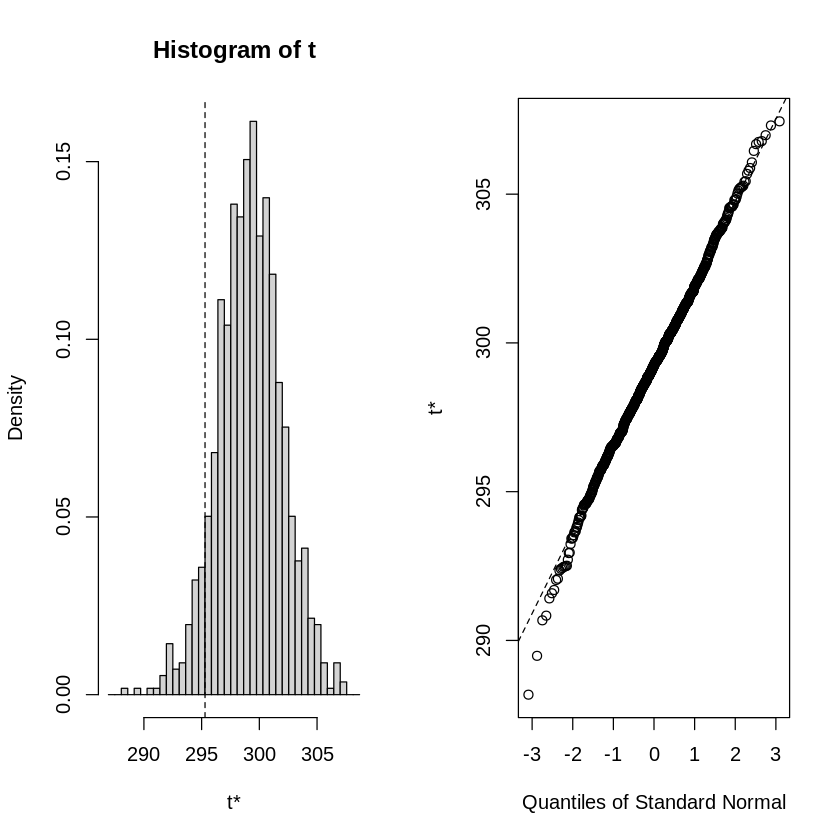

In [ ]:
plot(results)

In [ ]:
?boot

The `boot()` function can generate both nonparametric and parametric resampling. For the nonparametric bootstrap, resampling methods include ordinary, balanced, antithetic and permutation. For the nonparametric bootstrap, stratified resampling is supported. Importance resampling weights can also be specified.

# Probabilistic Statistical Measures

Probabilistic model selection (or “information criteria”) provides an analytical technique for scoring and choosing among candidate models.

Models are scored on:
* their performance → how well a candidate model has performed on the training dataset → be evaluated using a probabilistic framework, such as log-likelihood under the framework of MLE
* based on the complexity of the model → how complicated the trained candidate model is after training → be evaluated as the number of df or parameters in the model

## AIC & BIC
AIC = Akaike Information Criterion

BIC = Bayesian Information Criterion

Starting with the Mallows’s $C_p$:
$$C_p = \overline{\mathrm{err}} + 2 \cdot \frac{d}{N}\hat{\sigma}_\epsilon^2$$

where $d$ is the number of predictors, $N$ is the number of observations in the training dataset and $\hat{\sigma}_\epsilon^2$ is an estimate of the noise variance, obtained from the mean-squared error of a low-bias model.

Using this function we adjust the training error by a factor proportional to the number of basis functions used.

$$\mathrm{AIC} = \frac{1}{N\sigma^2}(\mathrm{RSS} + 2d\sigma^2)$$

$$\mathrm{AIC} = -\frac{2}{N} \cdot \mathrm{LL} + 2 \cdot \frac{d}{N}$$

where LL is the log-likelihood of the model on the training dataset.

$$\mathrm{AIC}(\alpha) = \overline{\mathrm{err}}(\alpha) + 2 \cdot \frac{d(\alpha)}{N} \hat{\sigma}_\epsilon^2$$

The function AIC($\alpha$) provides an estimate of the test error curve, and we find the tuning parameter $\hat\alpha$ that minimizes it.

Mallows’s $C_p$ has been shown to be equivalent to Akaike information criterion in the special case of Gaussian linear regression.

$$\mathrm{BIC} = \frac{1}{N\sigma^2}(\mathrm{RSS} + log(N)d \cdot \sigma^2)$$

[1] 155.0101

[1] 177.057

[1] 154.3127

[1] 167.5408

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

(Intercept)           X      lcavol 
      2.449       1.014       0.125

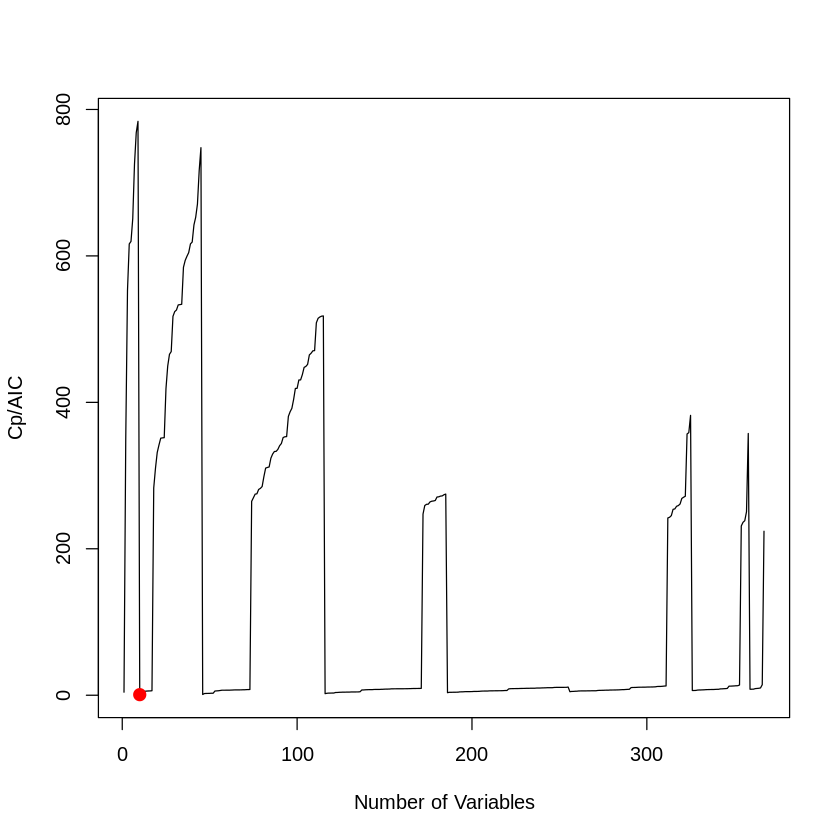

(Intercept)           X      lcavol 
      2.449       1.014       0.125

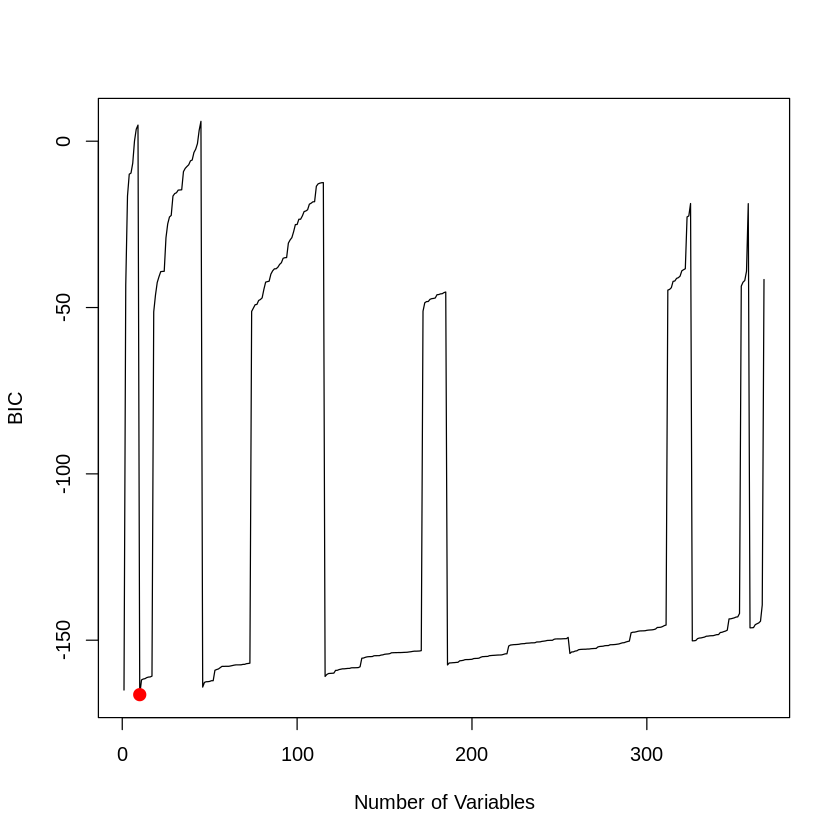

In [ ]:
# AIC & BIC
## subset selection for the data set "prostate"
prostate <- read.csv("https://raw.githubusercontent.com/omelnikov/data/main/prostate/prostate.data", sep="\t")
# partition the original data into training and testing datasets
train <- subset( prostate, train==TRUE )[,1:10]
test  <- subset( prostate, train==FALSE)[,1:10]
# standardization of predictors
trainst <- train
for(i in 1:8) {
  trainst[,i] <- trainst[,i] - mean(prostate[,i]);
  trainst[,i] <- trainst[,i]/sd(prostate[,i]);
}
testst <- test
for(i in 1:8) {
  testst[,i] <- testst[,i] - mean(prostate[,i]);
  testst[,i] <- testst[,i]/sd(prostate[,i]);
}

# full model
fitls <- lm( lpsa ~ lcavol+lweight+age+lbph+svi+lcp+gleason+pgg45, data=trainst )
AIC(fitls) # 155.0101
BIC(fitls) # 177.057

# reduced model
fitlsr <- lm( lpsa ~ lcavol+lweight+lbph+svi, data=trainst )
AIC(fitlsr) # 154.3127
BIC(fitlsr) # 167.5408


# load package "leaps" for function "regsubsets"
library("leaps")
prostate.leaps <- regsubsets( lpsa ~ . , data=trainst, nbest=70, really.big=TRUE )
prostate.leaps.sum <- summary( prostate.leaps )
names(prostate.leaps.sum)
#AIC
plot(prostate.leaps.sum$cp,xlab="Number of Variables",ylab="Cp/AIC",type='l')
cpmin<-which.min(prostate.leaps.sum$cp)
points(cpmin,prostate.leaps.sum$cp[cpmin],col="red",cex=2,pch=20)
round(coef(prostate.leaps,cpmin),3)

#BIC
bicmin<-which.min(prostate.leaps.sum$bic)
plot(prostate.leaps.sum$bic,xlab="Number of Variables",ylab="BIC",type='l')
points(bicmin,prostate.leaps.sum$bic[bicmin],col="red",cex=2,pch=20)
round(coef(prostate.leaps,bicmin),3)


## Minimum Description Length

$$MDL = L(h) + L(D|h)$$

where $h$ is the model, $D$ - the predictions made by the model,
$L(h)$ - the number of bits required to represent the model, and $L(D|h)$ - the number of bits required to represent the predictions from the model on the training dataset.

In words, The Minimum Description Length (MDL) principle recommends choosing the hypothesis that minimizes the sum of these two description lengths.

The MDL calculation is very similar to BIC and can be shown to be equivalent in some situations.

# Vapnik-Chervonenkis Dimension

The Capnik-Chervonenkis (VC) theory provides such a general measure of complexity, and gives associated bounds on the optimism.

The Vapnik-Chervonenkis dimension is a way of measuring the complexity of a class of functions by assessing how wiggly its members can be.

The VC dimension of the class {$f(x,\alpha)$} is defined to be the largest number of points (in some configuration) that can be shattered by members of {$f(x,\alpha)$}.

$$\mathrm{Err}_{\tau} \leq \overline{\mathrm{err}} + \frac{\epsilon}{2}(1 + \sqrt{1 + \frac{4 \cdot \overline{\mathrm{err}}}{\epsilon}})$$ (binary classification)

Vapnik's structural risk minimization (SRM) approach fits a nested sequence of increasing VC dimensions $h_1 < h_2 < ...$, and then chooses the model with the smallest value of the upper bound.